In [83]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import struct
import scipy.signal
from scipy.io.wavfile import read


In [84]:
#dataFilePath = 'RAW_DATA_000001_000002'
#dataFilePath = 'RAW_DATA_000020_000001'
#dataFilePath = 'RAW_DATA_000024_000001'
dataFilePath = 'RAW_DATA_000003_000001'
samplingFrequency = 1.5e6
centerFrequency = 173.5e6

In [85]:
import os
nSamples = int(os.path.getsize(dataFilePath) / 4)
signal = np.zeros(nSamples, dtype=np.complex64)
with open(dataFilePath, 'rb') as dataFile:
    for i in range(nSamples):
        sampleBytes = dataFile.read(4)
        re, im = struct.unpack("<2h", sampleBytes)
        signal[i] = float(re) / 0x7fff + float(im) * 1j / 0x7fff
t = np.arange(0, nSamples / samplingFrequency, 1/samplingFrequency)

In [86]:
# Generated signal parameters
#t_end = 4 # s
t_end = 8 # s
#f_s = 1000000 # Hz
f_s = 1.5e6 # Hz
#f_c = 172000000 # Hz
f_c = 173.5e6 # Hz
#f_t = 5000 # Hz offset from center
f_t = 20000
t_ping = 0.05 # s
ping_period = 1 # s
ping_power = -20 # dB
noise_power = -60 # dB
#noise_power = -30 # dB

In [87]:
# Computed signal parameters
ping_amplitude = 10 ** (ping_power / 20) # FS
ping_length = int(t_ping * f_s) # samples
ping_time_index = np.arange(0, ping_length)
ping_signal = np.cos(f_t / 2 * np.pi* ping_time_index) + 1j * np.sin(f_t / 2 * np.pi* ping_time_index)

ping_period_samples = ping_period * f_s
noise_snr = 10.0**(noise_power/10.0)


count = 0
for i in range(len(signal)):
    if (count >= 1425001) and (count < 1425000):
        if (i+75000) < len(signal):
            signal[i:i+75000] = signal[i:i+75000] + ping_signal
    elif count == 1425000:
        count = 0
    else:
        count += 1

<ipython-input-88-65a86a27f62e>:3: RuntimeWarning: divide by zero encountered in log10
  signal_power = 20 * np.log10(signal_magnitude)


Text(0, 0.5, 'Received Power (dB)')

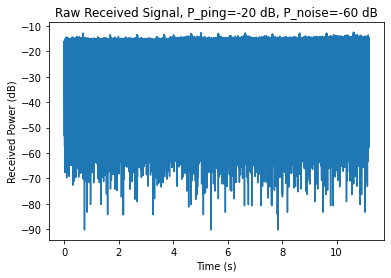

In [88]:
%matplotlib inline 
signal_magnitude = np.abs(signal)
signal_power = 20 * np.log10(signal_magnitude)
t = np.arange(len(signal_power)) / f_s
plt.plot(t, signal_power)
plt.title("Raw Received Signal, P_ping=%d dB, P_noise=%d dB" % (ping_power, noise_power))
plt.xlabel("Time (s)")
plt.ylabel("Received Power (dB)")


<IPython.core.display.Javascript object>


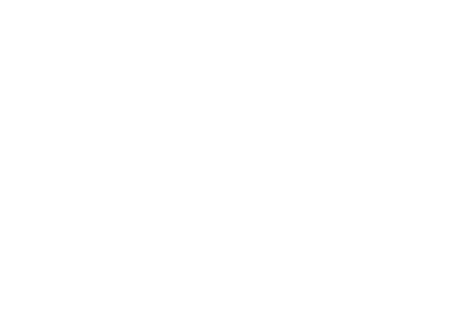

In [89]:
%matplotlib notebook
plt.plot(np.imag(signal))
plt.plot(np.real(signal))

<IPython.core.display.Javascript object>


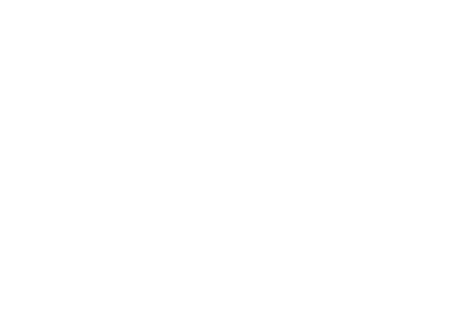

In [90]:
%matplotlib notebook
plt.plot(t, np.real(signal), label='Re')
plt.plot(t, np.imag(signal), label='Im')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (normalized)')
plt.title('Time Series Plot of %s' % (dataFilePath))
plt.title('Time Series Plot')
plt.legend(loc='upper right')
plt.savefig("Time series plot after adding 2nd ping")

In [91]:
signal.shape

(16779264,)

<IPython.core.display.Javascript object>


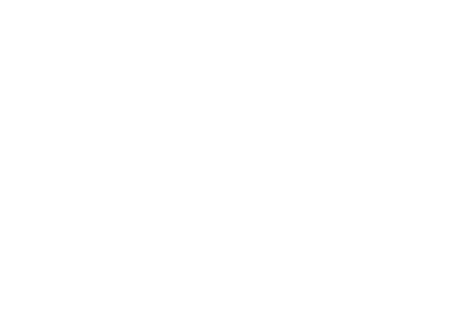

Text(0.5, 1.0, 'Time Series Plot of the Snippet containing the ping')

In [92]:
%matplotlib notebook
plt.plot(np.imag(ping_signal))
plt.plot(np.real(ping_signal))
plt.title('Time Series Plot of the Snippet containing the ping')

In [93]:
#nFFTs = 2048 # The original one we had
#nFFTs = 4096
nFFTs = 8192
#nFFTs = 262144
#signal = signal[2048:] # Use this when we set nFFT > 2048, like 4096, 8192

if signal.shape[0]%nFFTs != 0:
    signal = signal[signal.shape[0]%nFFTs:] 
    # Occurs so that our data is divisible by nFFTs, otherwise it breaks
    
fft_in = np.reshape(signal, (int(len(signal) / nFFTs), nFFTs))
fft_out = np.fft.fftshift(np.fft.fft(fft_in, norm=None))
fft_freqs = np.fft.fftshift(np.fft.fftfreq(nFFTs, 1/samplingFrequency))
fft_times = np.arange(0, len(signal) / samplingFrequency, nFFTs/samplingFrequency)
spectralPower = np.abs(20 * np.log10(fft_out)) # Calculates PSD

<IPython.core.display.Javascript object>


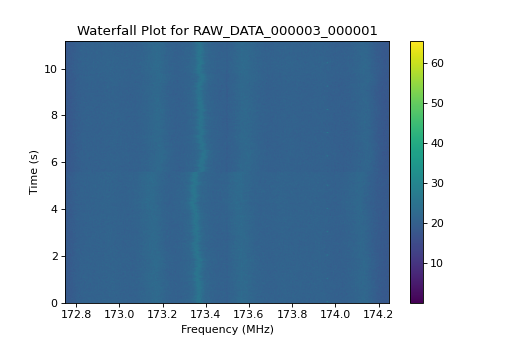

In [98]:
%matplotlib notebook
plt.imshow(spectralPower, origin='lower', extent=((fft_freqs[0] + centerFrequency) / 1e6, (fft_freqs[-1] + centerFrequency) / 1e6, fft_times[0], fft_times[-1]), aspect='auto')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time (s)')
#plt.xlim(173.96, 173.967)
#plt.xlim(173.497, 173.504)
#plt.ylim(4, 10)
plt.title('Waterfall Plot for %s' % (dataFilePath))
plt.colorbar()

In [95]:
import datetime # Used to test how fast code runs
from scipy.stats import skew
import random

In [96]:
skew_freqs = []
for i in range(spectralPower.shape[1]): 
    skew_freqs.append(skew(spectralPower[:,i]))

found_ping = np.argmax(skew_freqs)
our_freq = (fft_freqs[found_ping] + centerFrequency) / 1e6
print('Our ping frequency is: {}'.format(our_freq))

Our ping frequency is: 173.96435546875


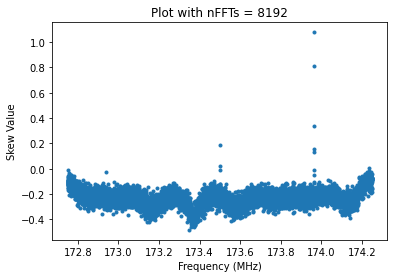

In [97]:
actual_freqs = (fft_freqs + centerFrequency) / 1e6
%matplotlib inline
plt.plot(actual_freqs,skew_freqs,'.')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Skew Value')
#plt.xlim(173.96, 173.967)
#plt.xlim(173.964, 173.965)
#plt.xlim(173.9642, 173.9646)
#plt.ylim(4, 10)
plt.title('Plot with nFFTs = {}'.format(nFFTs))
plt.savefig("Frequency vs Skew for %s" % (dataFilePath))